In [60]:
import pandas as pd

result_file = "../results3.pickle"
results = pd.read_pickle(result_file)
results.head()

,trans,past_context,gpos,gquat,npss,npss_weights,data_index,sequence_filename
0,5,1,0.039397,0.054695,"[0.0028786063, 0.0, 0.0, 0.043048203, 0.0, 0.0...","[3.192971e-05, 12.80676, 12.193179, 2.8239727e...",0,aiming2_subject5.bvh
1,5,1,0.024574,0.030394,"[0.062265933, 8.940697e-07, 4.7683716e-07, 0.6...","[0.0005463717, 12.979983, 12.01911, 8.7879234e...",1,aiming2_subject5.bvh
2,5,1,0.093931,0.069690,"[0.0064738393, 3.2305717e-05, 8.7320805e-05, 0...","[0.044314034, 14.962804, 9.971826, 0.011782687...",2,aiming2_subject5.bvh
3,5,1,0.110457,0.089005,"[0.22680163, 2.9802322e-07, 5.364418e-07, 0.02...","[0.0015599529, 14.571269, 10.399335, 0.0271650...",3,aiming2_subject5.bvh
4,5,1,0.088998,0.099834,"[0.061165094, 1.847744e-05, 2.8014183e-05, 0.1...","[0.01625105, 13.4078455, 11.532156, 0.03584794...",4,aiming2_subject5.bvh


In [ ]:
print(results["trans"].unique())
print(results["sequence_filename"].unique())
print(results["past_context"].unique())
print(results["data_index"].min(), results["data_index"].max())

[ 5 15 30 45]
['aiming2_subject5.bvh' 'dance2_subject5.bvh' 'fallAndGetUp1_subject5.bvh'
 'fight1_subject5.bvh' 'ground1_subject5.bvh' 'jumps1_subject5.bvh'
 'obstacles1_subject5.bvh' 'obstacles2_subject5.bvh'
 'obstacles6_subject5.bvh' 'pushAndStumble1_subject5.bvh'
 'run1_subject5.bvh' 'walk1_subject5.bvh' 'walk3_subject5.bvh']
[ 1  2  3  4  5  6  7  8  9 10]
0 2231


# Per file result

group per transition length, then by sequence_filename and calculate mean of each of metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Group and aggregate
per_file_dataset_results = (
    results.drop(columns=["data_index"])
    .groupby(['trans', 'sequence_filename', 'past_context'])
    .agg({
        "gpos": ["mean", "std"],
        "gquat": ["mean", "std"],
        "npss": [("arr", lambda arr: np.stack(arr.to_numpy()))],
        "npss_weights": [("arr", lambda arr: np.stack(arr.to_numpy()))]
    })
    .reset_index()
)

print(per_file_dataset_results.columns)
# Flatten multi-indexed columns
per_file_dataset_results.columns = [
    "_".join(col).strip("_") if isinstance(col, tuple) else col
    for col in per_file_dataset_results.columns
]
print(per_file_dataset_results.columns)


per_file_dataset_results["npss_weighted"] = per_file_dataset_results.apply(
    lambda row: np.sum(
        np.array(row["npss_arr"]) *
        (np.array(row["npss_weights_arr"]) / np.sum(row["npss_weights_arr"]))
    ),
    axis=1
)

# Drop raw weight arrays
per_file_dataset_results = per_file_dataset_results.drop(columns=["npss_arr", "npss_weights_arr"])
per_file_dataset_results.reset_index(drop=True, inplace=True)

print(per_file_dataset_results.columns)
print(per_file_dataset_results.head())

trans_values = per_file_dataset_results["trans"].unique()
seq_values = per_file_dataset_results["sequence_filename"].unique()

for metric in ["gpos", "gquat", "npss_weighted"]:
    print(f"Metric: {metric}")
    fig, axes = plt.subplots(
        len(trans_values), len(seq_values),
        figsize=(5 * len(seq_values), 4 * len(trans_values)),
        sharex=True, sharey=False
    )
    if len(trans_values) == 1 and len(seq_values) == 1:
        axes = np.array([[axes]])  # ensure 2D array for consistency
    elif len(trans_values) == 1 or len(seq_values) == 1:
        axes = axes.reshape(len(trans_values), len(seq_values))

    for row, t in enumerate(trans_values):
        for col, seq in enumerate(seq_values):
            ax = axes[row, col]
            data = per_file_dataset_results[
                (per_file_dataset_results["trans"] == t) &
                (per_file_dataset_results["sequence_filename"] == seq)
            ]

            x = data["past_context"]
            if metric in ["gpos", "gquat"]:
                y = data[f"{metric}_mean"]
                yerr = data[f"{metric}_std"]
                ax.errorbar(x, y, yerr=yerr, label=metric, fmt='-o')
                y_min_idx = np.argmin(y)
                ax.annotate(
                    f"min={y.iloc[y_min_idx]:.3f}",
                    (x.iloc[y_min_idx], y.iloc[y_min_idx]),
                    textcoords="offset points", xytext=(0, 10),
                    ha="center", fontsize=8, color="red"
                )
                ax.set_ylabel(f"{metric} Mean ± Std")
            else:  # NPSS weighted
                y = data["npss_weighted"]
                ax.plot(x, y, "-o", label=metric)
                y_min_idx = np.argmin(y)
                ax.annotate(
                    f"min={y.iloc[y_min_idx]:.3f}",
                    (x.iloc[y_min_idx], y.iloc[y_min_idx]),
                    textcoords="offset points", xytext=(0, 10),
                    ha="center", fontsize=8, color="red"
                )
                ax.set_ylabel("NPSS Weighted")

            # annotate x=1 always
            if 1 in x.values:
                y_at_1 = y[x == 1].iloc[0]
                ax.annotate(
                    f"x=1: {y_at_1:.3f}",
                    (1, y_at_1),
                    textcoords="offset points", xytext=(0, -15),
                    ha="center", fontsize=8, color="blue"
                )

            ax.set_title(f"Transition: {t}, Sequence: {seq}")
            ax.set_xlabel("Past Context Length")
            ax.set_xticks(range(1, 11))        # force x-axis ticks 1–10
            ax.grid(True, linestyle="--", alpha=0.6)  # add grid
            ax.legend()

    plt.tight_layout()
    plt.show()


MultiIndex([(            'trans',     ''),
            ('sequence_filename',     ''),
            (     'past_context',     ''),
            (             'gpos', 'mean'),
            (             'gpos',  'std'),
            (            'gquat', 'mean'),
            (            'gquat',  'std'),
            (             'npss',  'arr'),
            (     'npss_weights',  'arr')],
           )
Index(['trans', 'sequence_filename', 'past_context', 'gpos_mean', 'gpos_std',
       'gquat_mean', 'gquat_std', 'npss_arr', 'npss_weights_arr'],
      dtype='object')
Index(['trans', 'sequence_filename', 'past_context', 'gpos_mean', 'gpos_std',
       'gquat_mean', 'gquat_std', 'npss_weighted'],
      dtype='object')
   trans     sequence_filename  past_context  gpos_mean  gpos_std  gquat_mean  \
0      5  aiming2_subject5.bvh             1   0.098417  0.044366    0.089787   
1      5  aiming2_subject5.bvh             2   0.081990  0.033385    0.080694   
2      5  aiming2_subject5.bvh       

# NPSS experiments

in paper experiments npss weights are normalized across whole benchmark dataset and then multiplied, summed. Problem is when I want to asses performance of model on each file seperately. This requires different level of aggregation and i want to see how results will look like on normalizing them across file/single interpolation.

In [ ]:
import pandas as pd

result_file = "../results2.pickle"
results = pd.read_pickle(result_file)
results.head()

,trans,past_context,gpos,gquat,npss,npss_weights,data_index,sequence_filename
0,15,0,0.038525,0.054768,"[3.6566687, 0.0, 0.0, 3.8205283, 0.0, 0.000725...","[0.00087469956, 115.243126, 109.75571, 0.00013...",0,aiming2_subject5.bvh
1,15,0,0.193839,0.159821,"[2.592054, 3.3080578e-05, 3.129244e-05, 1.5963...","[0.07384283, 117.3792, 107.4868, 0.027556384, ...",1,aiming2_subject5.bvh
2,15,0,0.429415,0.253881,"[0.015756905, 0.0002090931, 0.00044077635, 0.1...","[4.8030963, 123.55441, 88.740974, 3.80926, 167...",2,aiming2_subject5.bvh
3,15,0,0.341472,0.173236,"[1.7902017, 7.683039e-05, 4.4345856e-05, 0.010...","[0.03334993, 128.98517, 95.44024, 0.43521613, ...",3,aiming2_subject5.bvh
4,15,0,0.390053,0.267045,"[0.10176784, 0.00079387426, 0.00092458725, 0.0...","[0.86120355, 120.2206, 101.48361, 1.9824837, 1...",4,aiming2_subject5.bvh


In [16]:
import numpy as np
results["npss_weighted"] = (results["npss"] * results["npss_weights"]).apply(np.sum, axis=0)
results["npss_weighted"]

0            0.102850
1           15.564636
2           73.734772
3           34.036987
4           50.699921
             ...     
66955     5076.092773
66956     4274.698242
66957     6523.341309
66958    17517.722656
66959     6905.816406
Name: npss_weighted, Length: 66960, dtype: float32

In [17]:
results["npss_weights_sum"] =  results["npss_weights"].apply(np.sum, axis=0)
results["npss_weights_sum"]

0         4949.963867
1         4893.846680
2         4818.854004
3         4896.881348
4         4920.758789
             ...     
66955    44216.578125
66956    44181.429688
66957    43739.507812
66958    39836.824219
66959    41913.625000
Name: npss_weights_sum, Length: 66960, dtype: float32

Normalization per sequence

In [20]:
results["npss_normalized_per_sequence"] =  results["npss_weighted"] / results["npss_weights_sum"]
results["npss_normalized_per_sequence"]

0        0.000021
1        0.003180
2        0.015301
3        0.006951
4        0.010303
           ...   
66955    0.114801
66956    0.096753
66957    0.149141
66958    0.439737
66959    0.164763
Name: npss_normalized_per_sequence, Length: 66960, dtype: float32

In [19]:
results[['trans', 'sequence_filename', 'past_context','npss_weights_sum', 'npss_weighted' ]]

,trans,sequence_filename,past_context,npss_weights_sum,npss_weighted
0,15,aiming2_subject5.bvh,0,4949.963867,0.102850
1,15,aiming2_subject5.bvh,0,4893.846680,15.564636
2,15,aiming2_subject5.bvh,0,4818.854004,73.734772
3,15,aiming2_subject5.bvh,0,4896.881348,34.036987
4,15,aiming2_subject5.bvh,0,4920.758789,50.699921
...,...,...,...,...,...
66955,45,walk3_subject5.bvh,9,44216.578125,5076.092773
66956,45,walk3_subject5.bvh,9,44181.429688,4274.698242
66957,45,walk3_subject5.bvh,9,43739.507812,6523.341309
66958,45,walk3_subject5.bvh,9,39836.824219,17517.722656


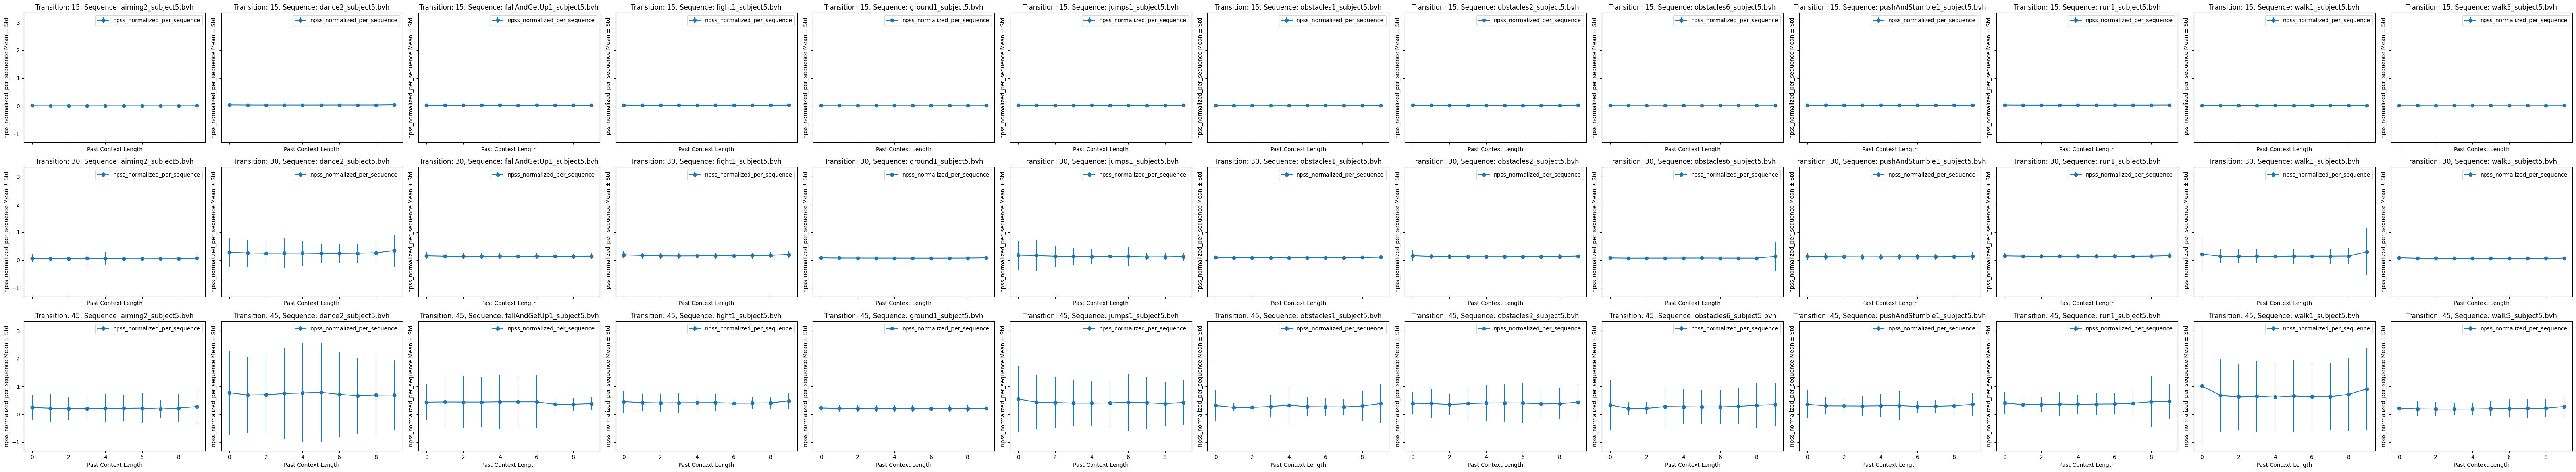

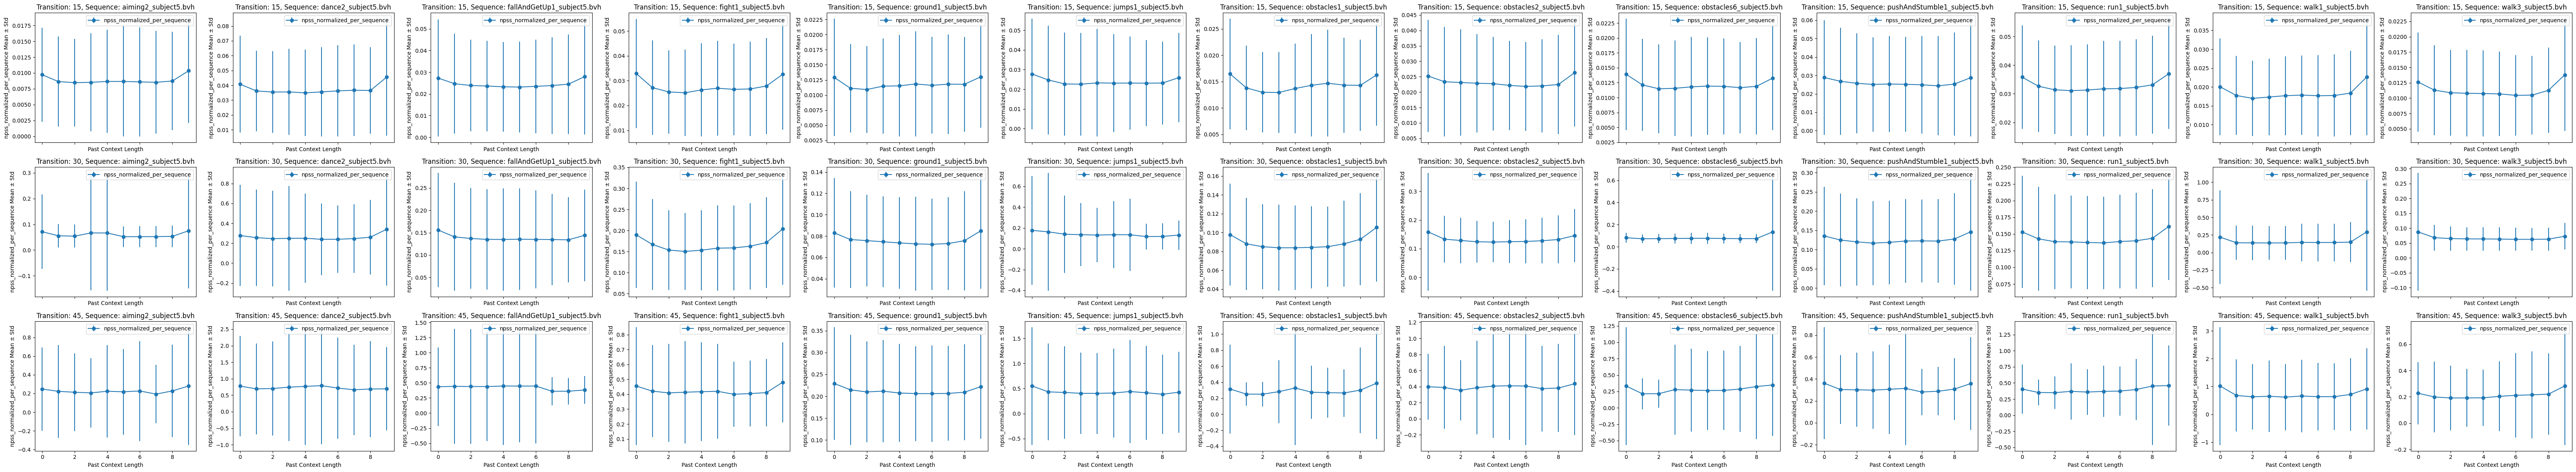

In [22]:
import matplotlib.pyplot as plt
grouped = results[['trans', 'sequence_filename', 'past_context', 'npss_normalized_per_sequence']].groupby(['trans', 'sequence_filename', 'past_context']).agg(["mean", "std"])

metric = 'npss_normalized_per_sequence'
trans_values = results["trans"].unique()
seq_values = results["sequence_filename"].unique()


fig, axes = plt.subplots(len(trans_values),len(seq_values),  figsize=(5 * len(seq_values), 4 * len(trans_values)), sharex=True, sharey=True)

for row, t in enumerate(trans_values):
    for col, seq in enumerate(seq_values):
        ax = axes[row, col]
        data = grouped.loc[(t, seq)]
        x = data.index.get_level_values('past_context')
        m_mean = data[metric]['mean']
        m_std = data[metric]['std']
        ax.errorbar(x, m_mean, yerr=m_std, label=metric, fmt='-o')
        ax.set_title(f"Transition: {t}, Sequence: {seq}")
        ax.set_xlabel('Past Context Length')
        ax.set_ylabel(metric +' Mean ± Std')
        ax.legend()
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(len(trans_values),len(seq_values),  figsize=(5 * len(seq_values), 4 * len(trans_values)), sharex=True, sharey=False)

for row, t in enumerate(trans_values):
    for col, seq in enumerate(seq_values):
        ax = axes[row, col]
        data = grouped.loc[(t, seq)]
        x = data.index.get_level_values('past_context')
        m_mean = data[metric]['mean']
        m_std = data[metric]['std']
        ax.errorbar(x, m_mean, yerr=m_std, label=metric, fmt='-o')
        ax.set_title(f"Transition: {t}, Sequence: {seq}")
        ax.set_xlabel('Past Context Length')
        ax.set_ylabel(metric +' Mean ± Std')
        ax.legend()
plt.tight_layout()
plt.show()
            
            


Normalization per file

In [ ]:
import matplotlib.pyplot as plt
grouped = results[['trans', 'sequence_filename', 'past_context', 'npss_normalized_per_sequence']].groupby(['trans', 'sequence_filename', 'past_context']).agg(["mean", "std"])

metric = 'npss_normalized_per_sequence'
trans_values = results["trans"].unique()
seq_values = results["sequence_filename"].unique()


fig, axes = plt.subplots(len(trans_values),len(seq_values),  figsize=(5 * len(seq_values), 4 * len(trans_values)), sharex=True, sharey=True)

for row, t in enumerate(trans_values):
    for col, seq in enumerate(seq_values):
        ax = axes[row, col]
        data = grouped.loc[(t, seq)]
        x = data.index.get_level_values('past_context')
        m_mean = data[metric]['mean']
        m_std = data[metric]['std']
        ax.errorbar(x, m_mean, yerr=m_std, label=metric, fmt='-o')
        ax.set_title(f"Transition: {t}, Sequence: {seq}")
        ax.set_xlabel('Past Context Length')
        ax.set_ylabel(metric +' Mean ± Std')
        ax.legend()
plt.tight_layout()
plt.show()
            


# benchmark whole dataset result

In [18]:
import pandas as pd
results = pd.read_pickle("../results3.pickle")
results.head()

,trans,past_context,gpos,gquat,npss,npss_weights,data_index,sequence_filename
0,5,1,0.039397,0.054695,"[0.0028786063, 0.0, 0.0, 0.043048203, 0.0, 0.0...","[3.192971e-05, 12.80676, 12.193179, 2.8239727e...",0,aiming2_subject5.bvh
1,5,1,0.024574,0.030394,"[0.062265933, 8.940697e-07, 4.7683716e-07, 0.6...","[0.0005463717, 12.979983, 12.01911, 8.7879234e...",1,aiming2_subject5.bvh
2,5,1,0.093931,0.069690,"[0.0064738393, 3.2305717e-05, 8.7320805e-05, 0...","[0.044314034, 14.962804, 9.971826, 0.011782687...",2,aiming2_subject5.bvh
3,5,1,0.110457,0.089005,"[0.22680163, 2.9802322e-07, 5.364418e-07, 0.02...","[0.0015599529, 14.571269, 10.399335, 0.0271650...",3,aiming2_subject5.bvh
4,5,1,0.088998,0.099834,"[0.061165094, 1.847744e-05, 2.8014183e-05, 0.1...","[0.01625105, 13.4078455, 11.532156, 0.03584794...",4,aiming2_subject5.bvh


results 3 

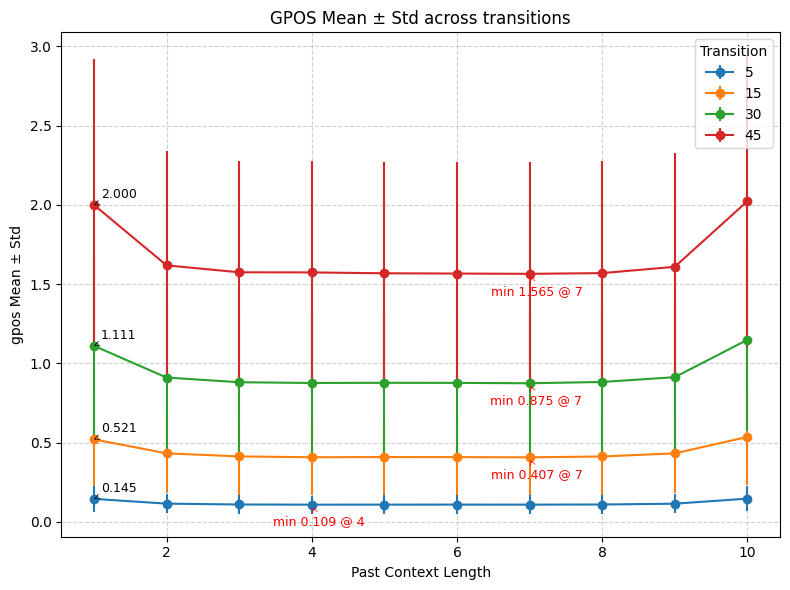

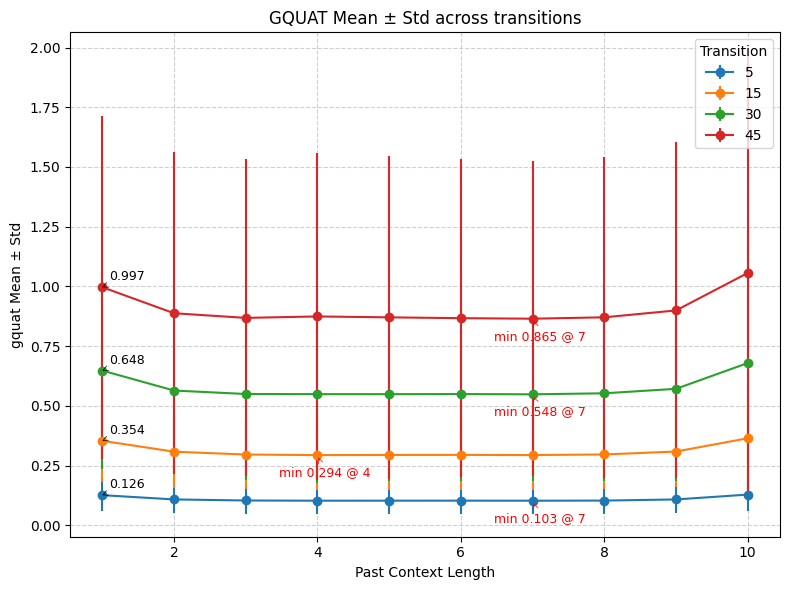

In [19]:
import matplotlib.pyplot as plt

whole_dataset_results = results.drop(columns=["data_index", "sequence_filename"])

gpos_whole_dataset_results = (
    whole_dataset_results
    .drop(columns=["npss", "npss_weights"])
    .groupby(['trans', 'past_context'])
    .agg(["mean", "std"])
    .reset_index()
)

for metric in ['gpos', 'gquat']:
    plt.figure(figsize=(8, 6))  # one figure per metric
    for t in gpos_whole_dataset_results["trans"].unique():
        data = gpos_whole_dataset_results[gpos_whole_dataset_results["trans"] == t]
        x = data['past_context']
        m_mean = data[metric]['mean']
        m_std = data[metric]['std']

        # Plot line with error bars
        plt.errorbar(x, m_mean, yerr=m_std, label=f"{t}", fmt='-o')

        # --- Annotation for past_context = 1 ---
        if 1 in x.values:
            val_at_1 = m_mean[x.values == 1].iloc[0]
            plt.annotate(
                f"{val_at_1:.3f}",
                (1, val_at_1),
                textcoords="offset points",
                xytext=(5, 5),
                ha="left",
                fontsize=9,
                color="black",
                arrowprops=dict(arrowstyle="->", lw=0.5)
            )

        # --- Annotation for minimum value ---
        min_idx = m_mean.idxmin()
        min_x = x.loc[min_idx]
        min_y = m_mean.loc[min_idx]
        plt.annotate(
            f"min {min_y:.3f} @ {min_x}",
            (min_x, min_y),
            textcoords="offset points",
            xytext=(5, -15),
            ha="center",
            fontsize=9,
            color="red",
            arrowprops=dict(arrowstyle="->", lw=0.5, color="red")
        )

    plt.title(f"{metric.upper()} Mean ± Std across transitions")
    plt.xlabel('Past Context Length')
    plt.ylabel(f"{metric} Mean ± Std")
    plt.legend(title="Transition")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


   trans  past_context                                               npss  \
0      5             1  [[0.0028786063, 0.0, 0.0, 0.043048203, 0.0, 0....   
1      5             2  [[0.00015300512, 0.0, 0.0, 0.15236431, 0.0, 0....   
2      5             3  [[0.15421075, 0.0, 0.0, 0.17896324, 0.0, 0.000...   
3      5             4  [[1.0384264, 0.0, 0.0, 0.50213003, 0.0, 8.6069...   
4      5             5  [[2.4828424, 0.0, 0.0, 1.3297181, 0.0, 0.00028...   

                                        npss_weights  npss_loss  
0  [[2.606562e-11, 1.0454719e-05, 9.953826e-06, 2...   0.001476  
1  [[2.606562e-11, 1.0454719e-05, 9.953826e-06, 2...   0.001220  
2  [[2.606562e-11, 1.0454719e-05, 9.953826e-06, 2...   0.001157  
3  [[2.606562e-11, 1.0454719e-05, 9.953826e-06, 2...   0.001146  
4  [[2.606562e-11, 1.0454719e-05, 9.953826e-06, 2...   0.001148  


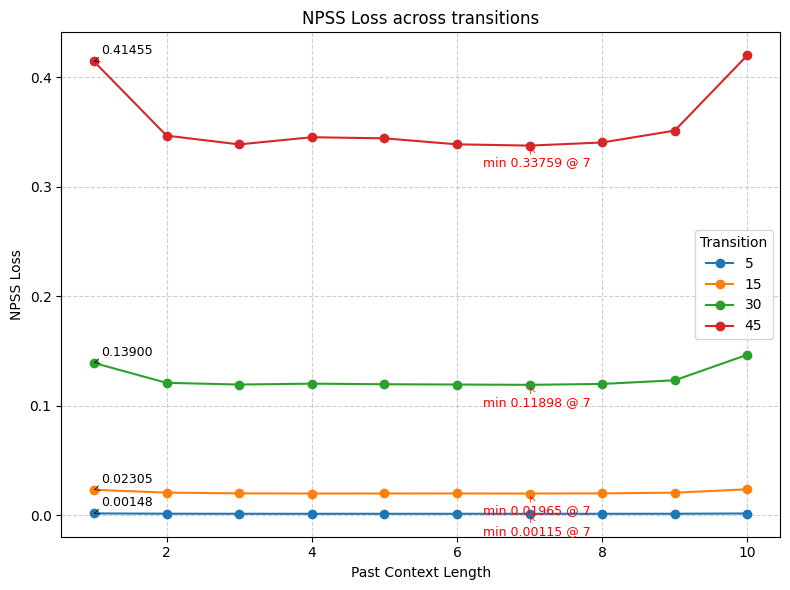

In [58]:
npss_whole_dataset_results = whole_dataset_results\
    .drop(columns=["gpos", "gquat"])\
    .groupby(['trans', 'past_context'])\
    .agg(lambda arr: np.stack(arr.to_numpy()))\
    .reset_index()
    
    
npss_whole_dataset_results["npss_weights"] = npss_whole_dataset_results["npss_weights"].apply(lambda x: x/np.sum(x))
npss_whole_dataset_results["npss_loss"] = npss_whole_dataset_results.apply(lambda row: np.sum(row["npss"] * row["npss_weights"]), axis=1)


print(npss_whole_dataset_results.head())


plt.figure(figsize=(8, 6))  
for t in npss_whole_dataset_results["trans"].unique():
    data = npss_whole_dataset_results[npss_whole_dataset_results["trans"] == t]
    x = data['past_context']

    # Plot line with error bars
    plt.plot(x, data["npss_loss"], '-o', label=f"{t}")

    # --- Annotation for past_context = 1 ---
    if 1 in x.values:
        val_at_1 = data["npss_loss"][x.values == 1].iloc[0]
        plt.annotate(
            f"{val_at_1:.5f}",
            (1, val_at_1),
            textcoords="offset points",
            xytext=(5, 5),
            ha="left",
            fontsize=9,
            color="black",
            arrowprops=dict(arrowstyle="->", lw=0.5)
        )

    # --- Annotation for minimum value ---
    min_idx = data["npss_loss"].idxmin()
    min_x = x.loc[min_idx]
    min_y = data["npss_loss"].loc[min_idx]
    plt.annotate(
        f"min {min_y:.5f} @ {min_x}",
        (min_x, min_y),
        textcoords="offset points",
        xytext=(5, -15),
        ha="center",
        fontsize=9,
        color="red",
        arrowprops=dict(arrowstyle="->", lw=0.5, color="red")
    )

plt.title("NPSS Loss across transitions")
plt.xlabel('Past Context Length')
plt.ylabel(f"NPSS Loss")
plt.legend(title="Transition")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
print(x.shape)
np.sum(x).shape


(2232, 88)


()

# grouped thematically files result